# Testing regularization approaches

Here's a notebook for playing with different penalties

In [1]:
# %matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt
from dement import DemEnt
import numpy as np
from scipy.optimize import minimize, check_grad
from scipy.special import erf
from scipy.special import expit

Initialize a model
--
We'll simulate a demographic history that suffers a crash then an exponential recovery

Define the time axis $\mathbf{t}$ (including the boundary at infinity) and the population size trajectory $\mathbf{y}$

In [2]:
t = np.arange(0, 10000, 40)

# constant
# y_true = 10000 * np.ones(len(t) - 1)

# crash followed by exponential growth
#y_true = 200 * (4 * np.exp(-t[1:]/10) + 1 + 2 * np.array(t[1:] > 400, float))

# oscillatory
#y_true = 1000 * (10 * np.sin(-t[:-1]/100) * ((t[:-1] - t[-2]) / t[-2])**2 + 10)

# sigmoid crash at 200 generations ago
y_true = 600 * (- .95 * expit(-(t[1:] - 200) / 10) + 1) + 600
#y_true = np.concatenate((y_true, [y_true[-1]]))

# hard crash 400 generations ago
#y_true = 200 * (np.array(t[1:] > 400, float)) + 200

In [3]:
len(y_true)

249

The number of sampled haplotypes $n$:

In [4]:
n = 600

Initialize dement object, and print its docstring:


    A class that implements the model of Rosen et al., but adds a Poisson random
    field for generating the SFS from ξ
    


/home/kameron/local/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


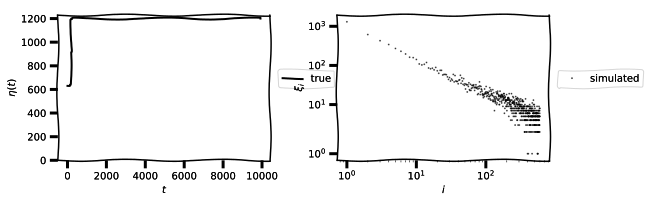

In [5]:
dement = DemEnt(n, t, y_true, infinite=False)
print(dement.__doc__)
dement.plot()

Inversion
--
### Initialization with constant model

We initialize by fitting a constant population size.
According to WSD's scribbles, the MLE assuming $\eta(t) = \eta_0$ (constant) is $\hat \eta_0 = \frac{S}{2 H_{n-1}}$, where $S$ is the number of segregating sites (the sum of the observed SFS vector) and $H_{n-1}$ is the $n$th harmonic number.
This was derived by using the well-known result (cited in Rosen et al.) that the expected SFS for a constant population is given by $\xi_i = \frac{2\eta_0}{i}$ (in units where $\eta$ is the population-scaled mutation rate).
Then the likelihood for $\eta_0$ is a Poisson random field parameterized by the $\xi_i$.

/home/kameron/local/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


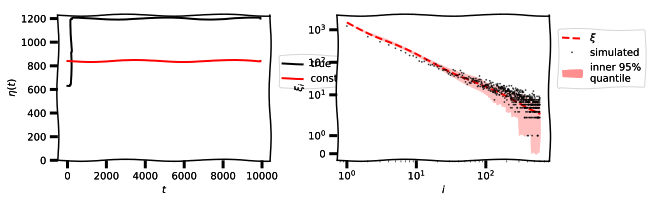

In [6]:
S = dement.sfs.sum()
H = (1 / np.arange(1, len(dement.sfs))).sum()
y_constant = (S / 2 / H) * np.ones(len(t) - 1)
dement.plot(y_constant, y_label='constant MLE')

### Regularized loss as a penalized log-likelihood
We must deal with the asymptotically constant boundary condition.
Standard regularizers blow up on the infinite epoch.
Let's use half Gaussian instead of Lebesgue measure on time to induce integrability: $\mathrm{d}\mu(t) = \frac{\sqrt{2}}{\sqrt{\pi}\tau}\exp\left(-\frac{1}{2}\left(\frac{t}{\tau}\right)^2\right)\mathrm{d}t,$
where $\tau$ is the characteristic time to asmptopia (the boundary of our time grid).
For example, a modified $L2$ would be
$$
R\left[\eta(t)\right] = \int_0^\infty \eta(t)^2 \mathrm{d}\mu(t) = \frac{\sqrt{2}}{\sqrt{\pi}\tau}\int_0^\infty \eta(t)^2 \exp\left(-\frac{1}{2}\left(\frac{t}{\tau}\right)^2\right)\mathrm{d}t.
$$
So the discretized problem is expressed in terms of the error function $\DeclareMathOperator{\erf}{erf}\erf(\cdot)$ if $\eta(t)$ is piecewise constant.
This will give extra (but finite) weight / penalty to the infinite epoch based on the survival function of $\mathrm{d}\mu(t)$.
We can tune how much weight the boundary epoch gets by tuning the width of the Gaussian.

In [7]:
def cost(y, y_prime, lambda_: float):
    # gaussian transformed measure
    #tau = 100 * dement.t[-2]
    #dmu = np.diff(erf(dement.t / tau / np.sqrt(2)))
    # generalized KL divergence (a Bregman divergence)
    #R_prior = ((y * np.log(y/y_prime) - y + y_prime) * dmu).sum()
    #R_prior = ((y - y_prime)**2 * dmu).sum()
    R_norm = (y**2).sum()
    # L2 on derivative
    #R_diff = (np.diff(y)**2 * dmu[1:]).sum()
    y_diff = np.diff(y)
    weight = np.ones(len(y_diff))
    # weight[-100:] = 1 + 10 * np.linspace(0, 1, 100)
    R_diff = ((weight * y_diff)**2).sum()
    return - dement.ell(y) + lambda_ * (0.001 * R_norm + R_diff)

### Minimize loss with L-BFGS-B

I'm using a constant L2 penalty to induce smoothness, and iterating a Bregman from a previous iterate's fit


In [ ]:
# Initial regularization strength
lambda_ = 1e-3

# initial and prior set to the constant population MLE
y = y_constant
y_init = y_constant

#for _ in range(100):
result = minimize(cost,
                  y_init,
                  args=(None, lambda_),
                  # jac=gradF,
                  method='L-BFGS-B',
                  options=dict(ftol=1e-6, maxfun=np.inf),
                  bounds=[(1, None)] * len(y))
assert result.success, result
y = result.x

/home/kameron/local/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


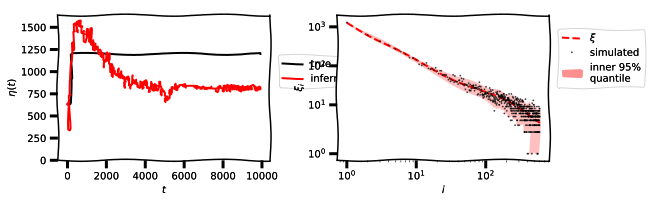

In [9]:
dement.plot(y, y_label='inferred ($\lambda = {:.2g}$)'.format(lambda_))    
plt.savefig("inf_false.svg")